In [1]:
import torch
torch.cuda.empty_cache()
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification,\
    TrainingArguments, Trainer, pipeline, DataCollatorWithPadding, set_seed
import evaluate
import numpy as np
import torch.nn as nn
import math
import time
from tqdm import tqdm

c:\Users\zebzi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seed(42)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
snli = load_dataset("snli")
# snli_test = load_dataset("json", data_files="SNLI_Dataset/snli_1.0_test.jsonl")
snli

Found cached dataset snli (C:/Users/zebzi/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)
100%|██████████| 3/3 [00:00<00:00, 175.42it/s]


DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
})

In [4]:
print(snli["train"]["premise"][0])
snli = snli.filter(lambda example: example["label"] != -1)

Loading cached processed dataset at C:\Users\zebzi\.cache\huggingface\datasets\snli\plain_text\1.0.0\1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b\cache-17e02a99a93fd477.arrow
Loading cached processed dataset at C:\Users\zebzi\.cache\huggingface\datasets\snli\plain_text\1.0.0\1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b\cache-b71979dc8e6f8a8f.arrow
Loading cached processed dataset at C:\Users\zebzi\.cache\huggingface\datasets\snli\plain_text\1.0.0\1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b\cache-3ac348b3e4f4ff95.arrow


A person on a horse jumps over a broken down airplane.


In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [6]:
def preprocess_function(examples):
    return tokenizer(examples["premise"], truncation=True)
    
tokenized_snli= snli.map(preprocess_function, batched=True)

Loading cached processed dataset at C:\Users\zebzi\.cache\huggingface\datasets\snli\plain_text\1.0.0\1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b\cache-779003f38358522f.arrow
100%|██████████| 550/550 [00:36<00:00, 15.10ba/s]
Loading cached processed dataset at C:\Users\zebzi\.cache\huggingface\datasets\snli\plain_text\1.0.0\1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b\cache-3a56d3f6fa57c175.arrow


In [7]:
def preprocess_function(examples):
    return tokenizer(examples["hypothesis"], truncation=True)
    
tokenized_snli= snli.map(preprocess_function, batched=True)

100%|██████████| 10/10 [00:01<00:00,  9.93ba/s]


In [8]:
print(tokenized_snli["train"]["hypothesis"][0])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

A person is training his horse for a competition.


In [9]:
accuracy = evaluate.load("accuracy")

In [10]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = numpy.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [11]:
# Is this necessary? yes
id2label = {0: "entailment", 1: "neutral", 2:"contradiction"}
label2id = {"entailment": 0, "neutral": 1, "contradiction": 2}
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [12]:
train_loss_list = []
train_acc_list = []
eval_loss_list = []
eval_acc_list = []
time_per_epoch_list = []

In [13]:
class CustomTrainer(Trainer):
    def _inner_training_loop(
        self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None
    ):
        number_of_epochs = args.num_train_epochs
        start = time.time()
        train_loss=[]
        train_acc=[]
        eval_acc=[]

        criterion = torch.nn.CrossEntropyLoss().to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)
        
        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader()

        for epoch in range(number_of_epochs):
            train_loss_per_epoch = 0
            train_acc_per_epoch = 0
            with tqdm(train_dataloader, unit="batch") as training_epoch:
                training_epoch.set_description(f"Training Epoch {epoch}")
                for step, inputs in enumerate(training_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    # forward pass
                    self.optimizer.zero_grad()
                    output = model(inputs['input_ids'])
                    # get the loss
                    loss = criterion(output['logits'], labels)
                    train_loss_per_epoch += loss.item()
                    #calculate gradients
                    loss.backward()
                    #update weights
                    self.optimizer.step()
                    train_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
            # adjust the learning rate
            self.scheduler.step()
            train_loss_per_epoch /= len(train_dataloader)
            train_acc_per_epoch /= (len(train_dataloader)*batch_size)
            
            
            eval_loss_per_epoch = 0
            eval_acc_per_epoch = 0
            with tqdm(eval_dataloader, unit="batch") as eval_epoch:
                eval_epoch.set_description(f"Evaluation Epoch {epoch}")
                for step, inputs in enumerate(eval_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    with torch.no_grad():
                        output = model(inputs['input_ids'])
                        loss = criterion(output['logits'], labels)
                        eval_loss_per_epoch += loss.item()
                        eval_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
            eval_loss_per_epoch /= (len(eval_dataloader))
            eval_acc_per_epoch /= (len(eval_dataloader)*batch_size)
        
            
            print(f'\tTrain Loss: {train_loss_per_epoch:.3f} | Train Acc: {train_acc_per_epoch*100:.2f}%')
            print(f'\tEval Loss: {eval_loss_per_epoch:.3f} | Eval Acc: {eval_acc_per_epoch*100:.2f}%')
            train_loss_list.append(train_loss_per_epoch)
            train_acc_list.append(train_acc_per_epoch)
            eval_loss_list.append(eval_loss_per_epoch)
            eval_acc_list.append(eval_acc_per_epoch)
            time_per_epoch_list.append((time.time()-start)/60)
    
        print(f'Time: {(time.time()-start)/60:.3f} minutes')

In [14]:
# https://huggingface.co/transformers/v4.4.2/main_classes/trainer.html#trainingarguments
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=1e-5,
    per_device_train_batch_size=16, # was 32
    per_device_eval_batch_size=16,  # was 32
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# https://huggingface.co/transformers/v4.4.2/main_classes/trainer.html#id1
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_snli["train"],
    eval_dataset=tokenized_snli["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: hypothesis, premise. If hypothesis, premise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: hypothesis, premise. If hypothesis, premise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Evaluation Epoch 0: 100%|██████████| 614/614 [00:09<00:00, 65.92batch/s]


	Train Loss: 0.823 | Train Acc: 62.80%
	Eval Loss: 0.770 | Eval Acc: 66.04%


Evaluation Epoch 1: 100%|██████████| 614/614 [00:09<00:00, 66.41batch/s]


	Train Loss: 0.712 | Train Acc: 69.26%
	Eval Loss: 0.766 | Eval Acc: 66.93%


Evaluation Epoch 2: 100%|██████████| 614/614 [00:12<00:00, 50.40batch/s]


	Train Loss: 0.578 | Train Acc: 76.08%
	Eval Loss: 0.809 | Eval Acc: 66.91%


Evaluation Epoch 3: 100%|██████████| 614/614 [00:12<00:00, 50.72batch/s]


	Train Loss: 0.387 | Train Acc: 84.65%
	Eval Loss: 1.030 | Eval Acc: 65.84%


Evaluation Epoch 4: 100%|██████████| 614/614 [00:13<00:00, 44.83batch/s]


	Train Loss: 0.253 | Train Acc: 90.21%
	Eval Loss: 1.317 | Eval Acc: 65.54%


Evaluation Epoch 5: 100%|██████████| 614/614 [00:13<00:00, 46.69batch/s]


	Train Loss: 0.186 | Train Acc: 92.84%
	Eval Loss: 1.513 | Eval Acc: 64.81%


Evaluation Epoch 6: 100%|██████████| 614/614 [00:12<00:00, 48.84batch/s]


	Train Loss: 0.147 | Train Acc: 94.26%
	Eval Loss: 1.732 | Eval Acc: 64.64%


Evaluation Epoch 7: 100%|██████████| 614/614 [00:12<00:00, 48.58batch/s]


	Train Loss: 0.123 | Train Acc: 95.08%
	Eval Loss: 1.965 | Eval Acc: 65.12%


Evaluation Epoch 8: 100%|██████████| 614/614 [00:12<00:00, 50.43batch/s]


	Train Loss: 0.107 | Train Acc: 95.55%
	Eval Loss: 1.952 | Eval Acc: 64.40%


Evaluation Epoch 9: 100%|██████████| 614/614 [00:11<00:00, 53.35batch/s]


	Train Loss: 0.096 | Train Acc: 95.88%
	Eval Loss: 2.084 | Eval Acc: 64.65%
Time: 516.427 minutes


In [15]:
model.save_pretrained("C:/Users/zebzi/Documents/School/Senior_Year/CSCI 5541/NLP/modelSaver")

Configuration saved in C:/Users/zebzi/Documents/School/Senior_Year/CSCI 5541/NLP/modelSaver\config.json
Model weights saved in C:/Users/zebzi/Documents/School/Senior_Year/CSCI 5541/NLP/modelSaver\pytorch_model.bin


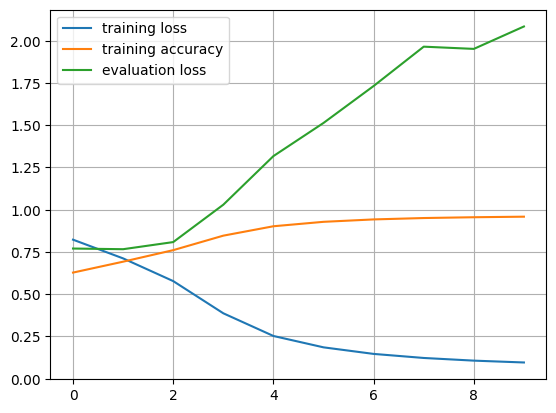

In [27]:
import matplotlib.pyplot as plt

# Data for plotting
t = np.arange(0.0, 100, 1)

# fig, ax = plt.subplots()
plt.plot(train_loss_list, label="training loss")
plt.plot(train_acc_list, label="training accuracy")
# plt.plot(eval_loss_list, label="evaluation loss")
plt.plot(eval_acc_list, label="evaluation accuracy")
plt.legend()
# ax.set(xlabel='time (s)', ylabel='voltage (mV)',
#        title='About as simple as it gets, folks')
plt.grid()

# fig.savefig("test.png")
plt.show()